In [12]:
import numpy as np
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from funcs import load_stocks_dataframe

In [2]:
df = load_stocks_dataframe()
df = df.dropna()

In [3]:
df.head()

,Date,GrowthStock_AdjClose,GrowthStock_PercentChange,ValueStock_AdjClose,ValueStock_PercentChange,Treasury10yr_AdjClose,Treasury10yr_PercentChange,Treasury10yr_Diff,exchange,exchange_PercentChange,exchange_Diff,inflation5yr,inflation5yr_PercentChange,inflation5yr_Diff,CPI,CPI_PercentChange,CPI_Diff
712,2003-04-01,8.603225,0.010614,26.337534,0.016642,3.827,0.001046,0.004,1.4729,0.002314,0.0034,1.64,-0.006061,-0.01,2.17513,-0.034786,-0.07839
713,2003-04-02,8.835845,0.027039,27.103275,0.029074,3.932,0.027437,0.105,1.4762,0.002240,0.0033,1.66,0.012195,0.02,2.17513,-0.034786,-0.07839
714,2003-04-03,8.831999,-0.000435,26.878065,-0.008309,3.916,-0.004069,-0.016,1.4760,-0.000135,-0.0002,1.64,-0.012048,-0.02,2.17513,-0.034786,-0.07839
715,2003-04-04,8.824308,-0.000871,27.038921,0.005985,3.944,0.007150,0.028,1.4720,-0.002710,-0.0040,1.63,-0.006098,-0.01,2.17513,-0.034786,-0.07839
716,2003-04-07,8.828156,0.000436,27.109701,0.002618,4.014,0.017748,0.070,1.4843,0.008356,0.0123,1.61,-0.012270,-0.02,2.17513,-0.034786,-0.07839


### Running on Growth Stocks

In [46]:
growth_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "Treasury10yr_PercentChange": df[["Treasury10yr_PercentChange"]],
            "inflation5yr_PercentChange": df[["inflation5yr_PercentChange"]],
            "CPI_PercentChange"         : df[["CPI_PercentChange"]]
        },
        {
            "GrowthStock_PercentChange" : df[["GrowthStock_PercentChange"]]
        }
    )
)

len(growth_dataset)

3696

In [47]:
growth_dataset.take

<bound method DatasetV2.take of <TensorSliceDataset element_spec=({'Treasury10yr_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None), 'inflation5yr_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None), 'CPI_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None)}, {'GrowthStock_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None)})>>

In [37]:
# train, test split
train_size = int(0.7*(len(growth_dataset)))
val_size = int(0.3*(len(growth_dataset)))
train = growth_dataset.take(train_size)
val   = growth_dataset.skip(train_size).take(val_size)

In [78]:
# inputs
treasury_input = keras.Input(
    shape = (1,), 
    name = "Treasury10yr_PercentChange",
    dtype = "float64"
)

inflation_input = keras.Input(
    shape = (1,), 
    name = "inflation5yr_PercentChange",
    dtype = "float64"
)

CPI_input = keras.Input(
    shape = (1,), 
    name = "CPI_PercentChange",
    dtype = "float64"
)

In [79]:
# pipeline for treasury
treasury_features = Dense(300, activation='relu')(treasury_input)
treasury_features = Dense(300, activation='relu')(treasury_features)
treasury_features = Dropout(0.2)(treasury_features)
treasury_features = Dense(300, activation='relu')(treasury_features)

# pipeline for inflation
inflation_features = Dense(300, activation='relu')(inflation_input)
inflation_features = Dense(300, activation='relu')(inflation_features)
inflation_features = Dropout(0.2)(inflation_features)
inflation_features = Dense(300, activation='relu')(inflation_features)

# pipeline for CPI
CPI_features = Dense(300, activation='relu')(CPI_input)
CPI_features = Dense(300, activation='relu')(CPI_features)
CPI_features = Dropout(0.2)(CPI_features)
CPI_features = Dense(300, activation='relu')(CPI_features)

In [80]:
# concatenation
main = layers.concatenate([treasury_features, inflation_features, CPI_features], axis = 1)

In [81]:
# output layer
main = layers.Dense(200, activation='relu')(main)
main = layers.Dense(200, activation='relu')(main)
output = layers.Dense(1, name = "GrowthStock_PercentChange")(main)

In [82]:
# create the model
model = keras.Model(
    inputs = [treasury_input, inflation_input, CPI_input],
    outputs = output
)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Treasury10yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 inflation5yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 CPI_PercentChange (InputLayer)  [(None, 1)]         0           []                               
                                                                                            

In [83]:
# specify loss function
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

# train the model
history = model.fit(train, 
                    validation_data=val,
                    epochs = 20)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2574/2587 [============================>.] - ETA: 0s - loss: 6.9659e-04 - mean_squared_error: 6.9659e-04WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f96589358c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRA

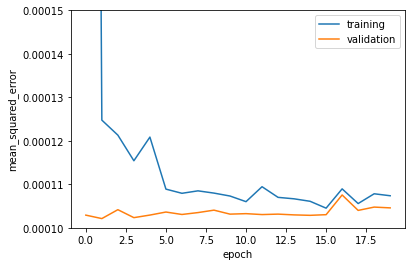

In [91]:
plt.plot(history.history["mean_squared_error"], label = "training")
plt.plot(history.history["val_mean_squared_error"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "mean_squared_error")
plt.ylim(0.0001, 0.00015)
plt.legend()

plt.savefig("growth_mixed_features.png")

### Running on Value Stocks

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Treasury10yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 inflation5yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 CPI_PercentChange (InputLayer)  [(None, 1)]         0           []                               
                                                                                            

Epoch 8/20
2587/2587 [==============================] - 9s 3ms/step - loss: 1.2692e-04 - mean_squared_error: 1.2692e-04 - val_loss: 7.3714e-05 - val_mean_squared_error: 7.3714e-05
Epoch 9/20
2587/2587 [==============================] - 9s 3ms/step - loss: 1.2694e-04 - mean_squared_error: 1.2694e-04 - val_loss: 7.4591e-05 - val_mean_squared_error: 7.4591e-05
Epoch 10/20
2587/2587 [==============================] - 9s 3ms/step - loss: 1.2666e-04 - mean_squared_error: 1.2666e-04 - val_loss: 7.5000e-05 - val_mean_squared_error: 7.5000e-05
Epoch 11/20
2587/2587 [==============================] - 9s 3ms/step - loss: 1.2832e-04 - mean_squared_error: 1.2832e-04 - val_loss: 7.2962e-05 - val_mean_squared_error: 7.2962e-05
Epoch 12/20
2587/2587 [==============================] - 9s 4ms/step - loss: 1.2805e-04 - mean_squared_error: 1.2805e-04 - val_loss: 7.1245e-05 - val_mean_squared_error: 7.1245e-05
Epoch 13/20
2587/2587 [==============================] - 9s 4ms/step - loss: 1.2661e-04 - mean_sq

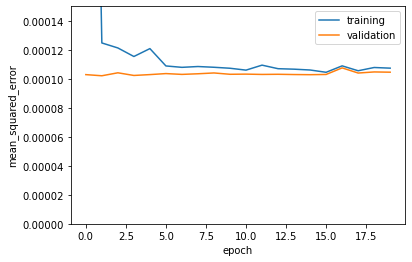

In [92]:
value_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "Treasury10yr_PercentChange": df[["Treasury10yr_PercentChange"]],
            "inflation5yr_PercentChange": df[["inflation5yr_PercentChange"]],
            "CPI_PercentChange"         : df[["CPI_PercentChange"]]
        },
        {
            "ValueStock_PercentChange" : df[["ValueStock_PercentChange"]]
        }
    )
)


# train, test split
train_size = int(0.7*(len(value_dataset)))
val_size = int(0.3*(len(value_dataset)))
train = value_dataset.take(train_size)
val   = value_dataset.skip(train_size).take(val_size)

# inputs
treasury_input = keras.Input(
    shape = (1,), 
    name = "Treasury10yr_PercentChange",
    dtype = "float64"
)

inflation_input = keras.Input(
    shape = (1,), 
    name = "inflation5yr_PercentChange",
    dtype = "float64"
)

CPI_input = keras.Input(
    shape = (1,), 
    name = "CPI_PercentChange",
    dtype = "float64"
)

# pipeline for treasury
treasury_features = Dense(300, activation='relu')(treasury_input)
treasury_features = Dense(300, activation='relu')(treasury_features)
treasury_features = Dropout(0.2)(treasury_features)
treasury_features = Dense(300, activation='relu')(treasury_features)

# pipeline for inflation
inflation_features = Dense(300, activation='relu')(inflation_input)
inflation_features = Dense(300, activation='relu')(inflation_features)
inflation_features = Dropout(0.2)(inflation_features)
inflation_features = Dense(300, activation='relu')(inflation_features)

# pipeline for CPI
CPI_features = Dense(300, activation='relu')(CPI_input)
CPI_features = Dense(300, activation='relu')(CPI_features)
CPI_features = Dropout(0.2)(CPI_features)
CPI_features = Dense(300, activation='relu')(CPI_features)

# concatenation
main = layers.concatenate([treasury_features, inflation_features, CPI_features], axis = 1)

# output layer
main = layers.Dense(200, activation='relu')(main)
main = layers.Dense(200, activation='relu')(main)
output = layers.Dense(1, name = "ValueStock_PercentChange")(main)

# create the model
model2 = keras.Model(
    inputs = [treasury_input, inflation_input, CPI_input],
    outputs = output
)

model2.summary()

# specify loss function
model2.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

# train the model
history2 = model2.fit(train, 
                    validation_data=val,
                    epochs = 20)

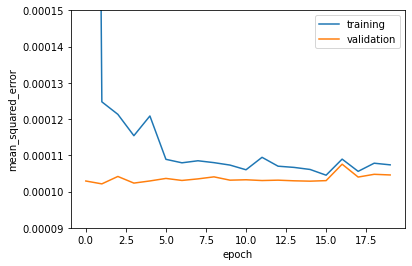

In [93]:
plt.plot(history.history["mean_squared_error"], label = "training")
plt.plot(history.history["val_mean_squared_error"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "mean_squared_error")
plt.ylim(0.00009, 0.00015)
plt.legend()

plt.savefig("value_mixed_features.png")

In [138]:
test_data =  tf.data.Dataset.from_tensor_slices(
    (
        {
            "Treasury10yr_PercentChange": np.array([-0.1]).reshape(-1,1),
            "inflation5yr_PercentChange": np.array([-0.05]).reshape(-1,1),
            "CPI_PercentChange"         : np.array([-0.08]).reshape(-1,1)
        }
    )
)

In [139]:
model2.predict(test_data)

array([[-0.01579231]], dtype=float32)